In [1]:
pip install aif360


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from clearbox_engine import Dataset, Preprocessor, TabularEngine, LabeledSynthesizer
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# Ensure reproducibility
np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
/usr/local/lib/python3.9/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /usr/local/lib/python3.9/site-packages/clearbox_engine/metrics/privacy/gower_matrix_c.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-3.9/usr/local/lib/python3.9/site-packages/clearbox_engine/metrics/priv

In [3]:
LICENSE_KEY = "licensekeyoverride2023@"

file_path = "https://raw.githubusercontent.com/gillus/Corso_MLOps/refs/heads/main/data"

train_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_training.csv"),
    target_column="income",
    regression=False
)

test_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_test.csv"),
    column_types=train_dataset.column_types,
    target_column=train_dataset.target_column,
    regression=train_dataset.regression
)

# Function to filter dataset based on the mask
def filter_dataset_for_positive_women(dataset):
    features_array = dataset.get_x()
    labels_array = dataset.get_y()
    features_df = pd.DataFrame(features_array, columns=dataset.x_columns())
    mask = (features_df["race"] == "Black") & (features_df["sex"] == "Female") & (labels_array == ">50K")
    filtered_features = features_df.loc[mask]
    filtered_labels = pd.Series(labels_array).loc[mask].reset_index(drop=True)
    combined_df = pd.concat([filtered_features.reset_index(drop=True), filtered_labels.rename("income")], axis=1)
    return Dataset(
        data=combined_df,
        column_types=dataset.column_types,
        target_column="income",
        regression=dataset.regression
    ), combined_df

# One-Hot Encode Original and Synthetic Datasets
def encode_dataset(dataset, encoder, categorical_columns, already_encoded=False):
    df = dataset.data.copy()
    target_column = dataset.target_column
    target_df = df[[target_column]] if target_column in df.columns else pd.DataFrame()

    if already_encoded:
        print(f"Skipping encoding for already encoded dataset: {df.columns}")
        return pd.concat([df, target_df], axis=1)

    # Transform only the specified categorical columns
    encoded_data = encoder.transform(df[categorical_columns])
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

    # Keep 'sex' and 'income' columns as they are
    preserved_columns = ['sex', target_column]
    preserved_df = df[preserved_columns]

    # Combine encoded and preserved columns
    numerical_df = df.drop(columns=categorical_columns + preserved_columns)
    final_df = pd.concat([numerical_df, preserved_df, encoded_df], axis=1)

    return final_df

# Apply filtering to both train and test datasets
train_filtered_dataset, df = filter_dataset_for_positive_women(train_dataset)
test_filtered_dataset, df_test = filter_dataset_for_positive_women(test_dataset)

# Combine all datasets to fit the encoder
combined_data = pd.concat([
    train_dataset.data, test_dataset.data, 
    train_filtered_dataset.data, test_filtered_dataset.data
], axis=0)

# Identify categorical columns
categorical_columns = combined_data.select_dtypes(include=['object']).columns
print("Categorical columns identified:", categorical_columns)

# Exclude 'sex' and 'income' from categorical columns
categorical_columns = combined_data.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col not in ['sex', 'income']]
print("Categorical columns to encode (excluding 'sex' and 'income'):", categorical_columns)

# Initialize and fit the OneHotEncoder on remaining categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')
encoder.fit(combined_data[categorical_columns])
print("Encoder fitted on categorical columns (excluding 'sex' and 'income').")

# Encode original datasets
encoded_train_dataset = encode_dataset(train_dataset, encoder, categorical_columns)
encoded_test_dataset = encode_dataset(test_dataset, encoder, categorical_columns)

# Encode filtered datasets
encoded_train_filtered = encode_dataset(train_filtered_dataset, encoder, categorical_columns)
encoded_test_filtered = encode_dataset(test_filtered_dataset, encoder, categorical_columns)

# Generate synthetic data for filtered datasets
def generate_multiple_synthetic_datasets(
    dataset_df, target_column, engine_class, num_datasets, epochs=5, learning_rate=0.001):
    # Wrap DataFrame into Dataset
    dataset = Dataset(
        data=dataset_df,
        target_column=target_column,
        column_types=None,
        regression=False,
    )
    preprocessor = Preprocessor(dataset)
    X = preprocessor.transform(dataset.get_x())

    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(dataset.get_y()).reshape(-1, 1)  # Convert to numerical and reshape
    
    # Ensure all data types are numerical
    X = X.astype(float)
    Y = Y.astype(float)

    engine = engine_class(
        license_key=LICENSE_KEY,
        layers_size=[50],
        x_shape=X.shape[1:],
        y_shape=Y.shape[1:],
        ordinal_feature_sizes=preprocessor.get_features_sizes()[0],
        categorical_feature_sizes=preprocessor.get_features_sizes()[1],
    )

    print("Training Tabular Engine...")
    engine.fit(X, y_train_ds=Y, epochs=epochs, learning_rate=learning_rate)

    synthesizer = LabeledSynthesizer(dataset, engine)

    # Generate multiple synthetic datasets and concatenate them
    synthetic_data_list = [synthesizer.generate(has_header=True) for _ in range(num_datasets)]
    concatenated_synthetic_data = pd.concat(synthetic_data_list, axis=0, ignore_index=True)
    
    return concatenated_synthetic_data


Categorical columns identified: Index(['work_class', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')
Categorical columns to encode (excluding 'sex' and 'income'): ['work_class', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
Encoder fitted on categorical columns (excluding 'sex' and 'income').


In [4]:
# Number of synthetic datasets to generate
num_datasets = 34


train_synthetic_combined_df = generate_multiple_synthetic_datasets(
    encoded_train_filtered,
    target_column="income",
    engine_class=TabularEngine,
    num_datasets=num_datasets
)

test_synthetic_combined_df = generate_multiple_synthetic_datasets(
    encoded_test_filtered,
    target_column="income",
    engine_class=TabularEngine,
    num_datasets=num_datasets
)

# Concatenate original and synthetic datasets
final_train_dataset = pd.concat([encoded_train_dataset, train_synthetic_combined_df], axis=0, ignore_index=True)
final_test_dataset = pd.concat([encoded_test_dataset, test_synthetic_combined_df], axis=0, ignore_index=True)

# Print shapes and column information
print("Final Train Dataset Shape:", final_train_dataset.shape)
print("Final Test Dataset Shape:", final_test_dataset.shape)

validation_dataset = Dataset.from_csv(
    os.path.join(file_path, "adult_validation.csv"),
    column_types=train_dataset.column_types,
    target_column=train_dataset.target_column,
    regression=train_dataset.regression
)

# Encode the validation dataset
encoded_validation_dataset = encode_dataset(validation_dataset, encoder, categorical_columns)

# Print validation dataset shape and columns for verification
print("Validation Dataset Shape:", encoded_validation_dataset.shape)

train_0 = encoded_train_dataset
train_transf_0 = final_train_dataset
test_0 = encoded_test_dataset
test_transf_0 = final_test_dataset
val_0 = encoded_validation_dataset


/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (85). n_quantiles is set to n_samples.
  warnings.warn(
2025-02-11 21:42:52.778 | INFO     | __main__:generate_multiple_synthetic_datasets:111 - I'm the Sept 2024 engine!


Clearbox AI Engine: your license is valid.
Training Tabular Engine...


Engine fitting in progress: 100%|██████████| 5/5 [00:01<00:00,  3.86epoch/s, Train loss:=5259454.0]
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (85). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (26). n_quantiles is set to n_samples.
  warnings.warn(
2025-02-11 21:43:01.727 | INFO     | __main__:generate_multiple_synthetic_datasets:111 - I'm the Sept 2024 engine!


Clearbox AI Engine: your license is valid.
Training Tabular Engine...


Engine fitting in progress: 100%|██████████| 5/5 [00:01<00:00,  4.89epoch/s, Train loss:=17578678.0]
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (26). n_quantiles is set to n_samples.
  warnings.warn(


Final Train Dataset Shape: (33052, 62)
Final Test Dataset Shape: (10974, 62)
Validation Dataset Shape: (4970, 62)


In [5]:
def preprocess_for_binary_label_dataset(df, target_column):
    df = df.copy()
    
    # Map target labels to numeric if present
    if target_column in df.columns:
        df[target_column] = df[target_column].map({'>50K': 1.0, '<=50K': 0.0})
    
    # Map 'sex' column to numeric if present
    if 'sex' in df.columns:
        df['sex'] = df['sex'].map({'Male': 1.0, 'Female': 0.0})
    
    # Ensure all values are numeric
    return df.astype(float)



In [ ]:
# Preprocess train and test datasets
processed_train = preprocess_for_binary_label_dataset(train_0, target_column="income")
processed_test = preprocess_for_binary_label_dataset(test_0, target_column="income")

# Update the protected attribute to use the correct column
protected_attributes = ['sex']

# Convert processed datasets to BinaryLabelDataset
train = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_train,
    label_names=["income"],  # Target column
    protected_attribute_names=protected_attributes
)

test = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_test,
    label_names=["income"],  # Target column
    protected_attribute_names=protected_attributes
)


# Evaluate fairness metrics
privileged_groups = [{'sex': 1}]  
unprivileged_groups = [{'sex': 0}]  


In [27]:
metric_train = BinaryLabelDatasetMetric(train, unprivileged_groups, privileged_groups)
print("Train Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_train.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train.disparate_impact():.4f}")

metric_test = BinaryLabelDatasetMetric(test, unprivileged_groups, privileged_groups)
print("\nTest Dataset (Before Transformation):")
print(f"  Statistical Parity Difference: {metric_test.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test.disparate_impact():.4f}")

Train Dataset (Before Transformation):
  Statistical Parity Difference: -0.2002
  Disparate Impact: 0.3622

Test Dataset (Before Transformation):
  Statistical Parity Difference: -0.1967
  Disparate Impact: 0.3654


In [28]:
# Preprocess transformed datasets to ensure compatibility with BinaryLabelDataset
processed_train_transf = preprocess_for_binary_label_dataset(train_transf_0, target_column="income")
processed_test_transf = preprocess_for_binary_label_dataset(test_transf_0, target_column="income")

# Convert transformed datasets to BinaryLabelDataset
train_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_train_transf,
    label_names=["income"],  # Target column
    protected_attribute_names=["sex"]  # Use 'sex' as it is not one-hot encoded
)

test_transf = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_test_transf,
    label_names=["income"],  # Target column
    protected_attribute_names=["sex"]  # Use 'sex' as it is not one-hot encoded
)

# Preprocess validation dataset to ensure compatibility with BinaryLabelDataset
processed_val = preprocess_for_binary_label_dataset(val_0, target_column="income")

# Convert validation dataset to BinaryLabelDataset
val = BinaryLabelDataset(
    favorable_label=1.0,
    unfavorable_label=0.0,
    df=processed_val,
    label_names=["income"],  # Target column
    protected_attribute_names=["sex"]  # Use 'sex' as it is not one-hot encoded
)



In [29]:
# Evaluate fairness metrics after applying LFR
metric_train_after = BinaryLabelDatasetMetric(train_transf, unprivileged_groups, privileged_groups)
print("\nTrain Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_train_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_train_after.disparate_impact():.4f}")

metric_test_after = BinaryLabelDatasetMetric(test_transf, unprivileged_groups, privileged_groups)
print("\nTest Dataset (After Transformation):")
print(f"  Statistical Parity Difference: {metric_test_after.mean_difference():.4f}")
print(f"  Disparate Impact: {metric_test_after.disparate_impact():.4f}")


Train Dataset (After Transformation):
  Statistical Parity Difference: 0.0020
  Disparate Impact: 1.0063

Test Dataset (After Transformation):
  Statistical Parity Difference: -0.0090
  Disparate Impact: 0.9709


In [30]:
# Ensure the classifier has a fixed random state and uses a deterministic solver
classifier = LogisticRegression(random_state=1, solver='liblinear', max_iter=1000)

In [31]:
# Train a classifier on original training data
classifier.fit(train.features, train.labels.ravel())

# Predict on validation set
val_scores = classifier.predict_proba(val.features)[:, 1] 

In [32]:
# Select best threshold for validation set
thresholds = np.arange(0.01, 1, 0.01)
val_balanced_accs = []

for threshold in thresholds:
    val_LR_predictions = (val_scores >= threshold).astype(int)

    val_with_LR_scores = copy.deepcopy(val)
    val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

    val_metric = ClassificationMetric(val, val_with_LR_scores,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)
    balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2
    val_balanced_accs.append(balanced_acc)

best_index = np.argmax(val_balanced_accs)
best_threshold = thresholds[best_index]
best_balanced_acc = val_balanced_accs[best_index]

print(f"Best Threshold (validation): {best_threshold}")
print(f"Best Balanced Accuracy (validation): {best_balanced_acc}")

Best Threshold (validation): 0.21000000000000002
Best Balanced Accuracy (validation): 0.8180075975488086


In [33]:
# Apply the best threshold to the test set
test_scores = classifier.predict_proba(test.features)[:, 1]
test_LR_predictions= (test_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_with_LR_scores = copy.deepcopy(test)
test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_metric = ClassificationMetric(test, test_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_metric.true_positive_rate()
true_negative_rate = test_metric.true_negative_rate()
balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy}")

# Statistical Parity Difference
statistical_parity_difference = test_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference}")

# Disparate Impact
disparate_impact = test_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact}")

# Average Odds Difference
average_odds_difference = test_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference}")

# Equal Opportunity Difference
equal_opportunity_difference = test_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference}")

# Theil Index
theil_index = test_metric.theil_index()
print(f"Theil Index (test): {theil_index}")

Balanced Accuracy (test): 0.8170604434495856
Statistical Parity Difference (test): -0.3549094738753072
Disparate Impact (test): 0.315560503843193
Average Odds Difference (test): -0.2037803062966457
Equal Opportunity Difference (test): -0.15025753050775392
Theil Index (test): 0.0773130419221293


In [35]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

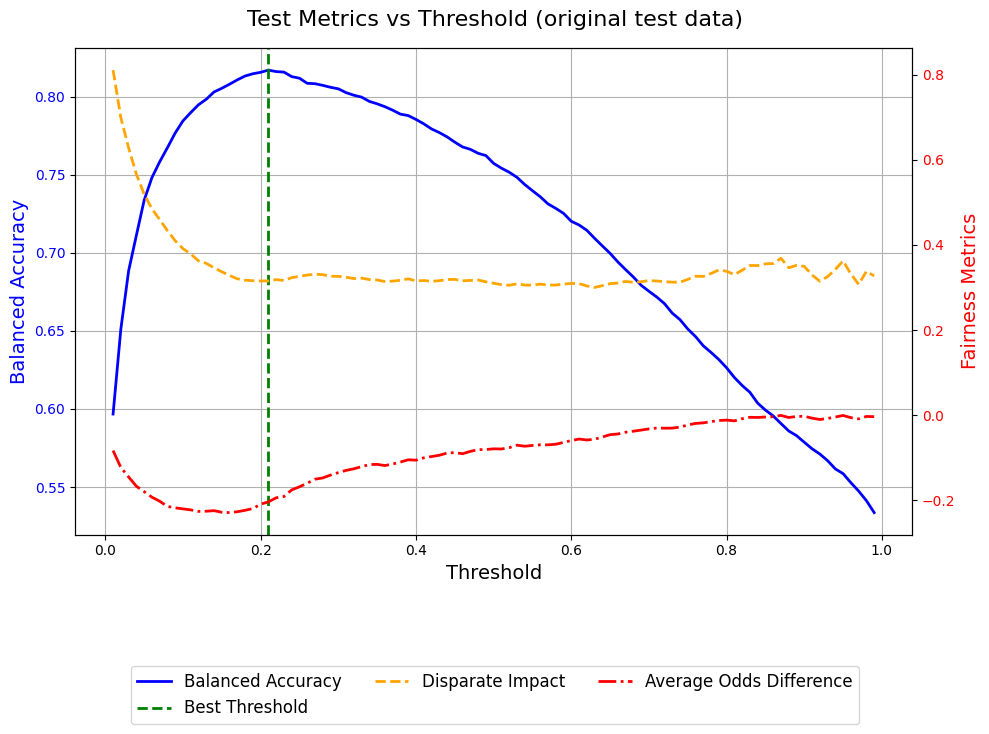

In [36]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [37]:
# Ensure the classifier has a fixed random state and uses a deterministic solver
classifier = LogisticRegression(random_state=1, solver='liblinear', max_iter=1000)

In [38]:
classifier.fit(train_transf.features, train_transf.labels.ravel())
# Apply the best threshold to the transf test set
test_transf_scores = classifier.predict_proba(test_transf.features)[:, 1]
test_transf_LR_predictions= (test_transf_scores >= best_threshold).astype(int)

# Create a copy of the test dataset and set predicted labels
test_transf_with_LR_scores = copy.deepcopy(test_transf)
test_transf_with_LR_scores.labels = test_transf_LR_predictions.reshape(-1, 1)

# Calculate fairness and performance metrics on the test set
test_transf_metric = ClassificationMetric(test_transf, test_transf_with_LR_scores,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

# Balanced Accuracy
true_positive_rate = test_transf_metric.true_positive_rate()
true_negative_rate = test_transf_metric.true_negative_rate()
balanced_accuracy_transf = (true_positive_rate + true_negative_rate) / 2
print(f"Balanced Accuracy (test): {balanced_accuracy_transf}")

# Statistical Parity Difference
statistical_parity_difference_transf = test_transf_metric.statistical_parity_difference()
print(f"Statistical Parity Difference (test): {statistical_parity_difference_transf}")

# Disparate Impact
disparate_impact_transf = test_transf_metric.disparate_impact()
print(f"Disparate Impact (test): {disparate_impact_transf}")

# Average Odds Difference
average_odds_difference_transf = test_transf_metric.average_odds_difference()
print(f"Average Odds Difference (test): {average_odds_difference_transf}")

# Equal Opportunity Difference
equal_opportunity_difference_transf = test_transf_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference (test): {equal_opportunity_difference_transf}")

# Theil Index
theil_index_transf = test_transf_metric.theil_index()
print(f"Theil Index (test): {theil_index_transf}")

Balanced Accuracy (test): 0.8021803622181192
Statistical Parity Difference (test): -0.1781088811006165
Disparate Impact (test): 0.6814663273790027
Average Odds Difference (test): -0.11247312865743
Equal Opportunity Difference (test): 0.041294675741772036
Theil Index (test): 0.07875801807304916


In [46]:
# Plot Test Metrics Over Thresholds
test_balanced_accs = []
test_disp_impacts = []
test_avg_odds_diffs = []

for threshold in thresholds:
    test_predictions = (test_scores >= threshold).astype(int)
    test_with_scores = copy.deepcopy(test)
    test_with_scores.labels = test_predictions.reshape(-1, 1)

    test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
    test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
    test_disp_impacts.append(test_metric.disparate_impact())
    test_avg_odds_diffs.append(test_metric.average_odds_difference())

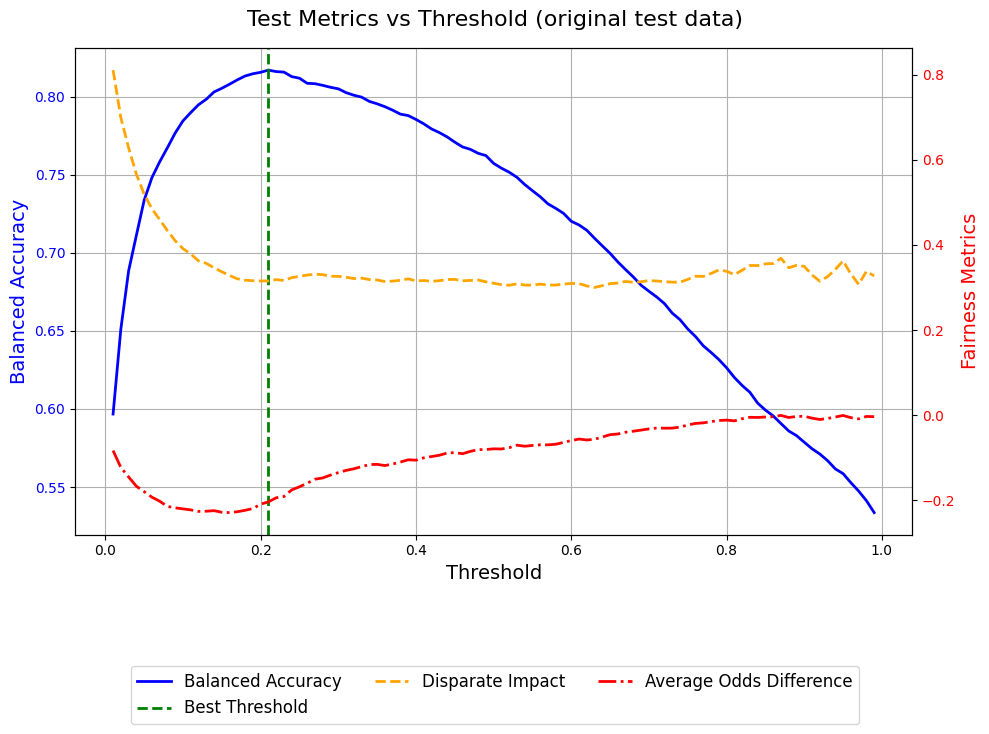

In [47]:
# Create the figure and primary y-axis for Balanced Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Balanced Accuracy
ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
ax1.set_xlabel("Threshold", fontsize=14)
ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid()

# Secondary y-axis for Disparate Impact and Equal Opportunity Difference
ax2 = ax1.twinx()

# Disparate Impact
ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

# Average Odds Difference
ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
ax2.tick_params(axis='y', labelcolor="red")

# Highlight the best threshold
ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

# Title and layout adjustments
fig.suptitle("Test Metrics vs Threshold (original test data)", fontsize=16)
fig.tight_layout()
plt.show()

In [48]:
results_data = {
    "Dataset": [
        "Train", "Train", "Test", "Test", 
        "Train", "Train", "Test", "Test", 
        "Validation", "Validation", 
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)",
        "Test (Original)", "Test (Transformed)"
    ],
    "Stage": [
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Before Transformation", "After Transformation", 
        "Before Transformation", "After Transformation",
        "Best Threshold (Validation)", "Best Threshold (Validation)",
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold", 
        "After Threshold", "After Threshold"
    ],
    "Metric": [
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Statistical Parity Difference", "Statistical Parity Difference",
        "Disparate Impact", "Disparate Impact",
        "Disparate Impact", "Disparate Impact",
        "Threshold", "Balanced Accuracy",
        "Balanced Accuracy", "Balanced Accuracy", 
        "Statistical Parity Difference", "Statistical Parity Difference", 
        "Disparate Impact", "Disparate Impact",
        "Average Odds Difference", "Average Odds Difference",
        "Equal Opportunity Difference", "Equal Opportunity Difference", 
        "Theil Index", "Theil Index"
    ],
    "Value": [
        metric_train.mean_difference(),
        metric_train_after.mean_difference(),
        metric_test.mean_difference(),
        metric_test_after.mean_difference(),
        metric_train.disparate_impact(),
        metric_train_after.disparate_impact(),
        metric_test.disparate_impact(),
        metric_test_after.disparate_impact(),
        best_threshold,
        best_balanced_acc,
        balanced_accuracy, balanced_accuracy_transf,
        statistical_parity_difference, statistical_parity_difference_transf,
        disparate_impact, disparate_impact_transf,
        average_odds_difference, average_odds_difference_transf,
        equal_opportunity_difference, equal_opportunity_difference_transf,
        theil_index, theil_index_transf
    ]
}

# Create the DataFrame
results_table = pd.DataFrame(results_data)
# Separate the data into three groups
fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
test_metrics = results_table.iloc[10:22].reset_index(drop=True)

# Name the tables
fairness_metrics.name = "Fairness Metrics Before and After Transformation"
validation_metrics.name = "Validation Metrics for Threshold Selection"
test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

# Display the tables with their names
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)

'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.200159
1,Train,After Transformation,Statistical Parity Difference,0.001977
2,Test,Before Transformation,Statistical Parity Difference,-0.196652
3,Test,After Transformation,Statistical Parity Difference,-0.009027
4,Train,Before Transformation,Disparate Impact,0.362220
5,Train,After Transformation,Disparate Impact,1.006300
6,Test,Before Transformation,Disparate Impact,0.365410
7,Test,After Transformation,Disparate Impact,0.970872


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.210000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.818008


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.817060
1,Test (Transformed),After Threshold,Balanced Accuracy,0.802180
2,Test (Original),After Threshold,Statistical Parity Difference,-0.354909
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.178109
4,Test (Original),After Threshold,Disparate Impact,0.315561
5,Test (Transformed),After Threshold,Disparate Impact,0.681466
6,Test (Original),After Threshold,Average Odds Difference,-0.203780
7,Test (Transformed),After Threshold,Average Odds Difference,-0.112473
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.150258
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.041295
